# Yvettes Notebook

In [9]:
import os
import json
from typing import Dict, List, Optional, Union, cast
import requests
from bs4 import BeautifulSoup
from env import github_token, github_username
import re
import pandas as pd
import time
import prepare as p
from sklearn.model_selection import train_test_split
import nltk.sentiment
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import model as m
import explore as e

In [2]:


import sklearn.preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import pandas as pd

### Acquire webscrape urls from repos and save to csv

Keytakaway from urls collection:
After some exploration of urls in github search of most starred repos we noticed that the page number in the url was the only change from one page to another. Creating a loop to change page when web scraping will allow us to 
iterate through pages and get more urls into our csv file.

We also notice that the link to the repo was under <a> class = "v-align-middle". We will add a forloop to scrape each link and remove the first "/" and save into csv file.
    
In total we were able to collect 1000 observation of urls 853 of which seem to be unique.

Pattern in urls:
#'search?q=stars%3A%3E0&s=stars&type=Repositories'
    #'search?p=2&q=stars%3A%3E0&s=stars&type=Repositories'
    #'search?p=3&q=stars%3A%3E0&s=stars&type=Repositories'
    
#https://github.com/search?q=stars%3A%3E0&s=stars&type=Repositories
#https://github.com/search?p=100&q=stars%3A%3E0&s=stars&type=Repositories

In [ ]:
# function for scraping 1000 observations of urls

#urls=[]
#for i in range(0,100):
#    url = f"https://github.com/search?p={i}&q=stars%3A%3E0&s=stars&type=Repositories"
#    reqs = requests.get(url)
#    soup = BeautifulSoup(reqs.text, 'html.parser')
#    time.sleep(2)
#    for link in soup.find_all('a',class_="v-align-middle"):
#        link = re.sub(r'/', '', link.get('href'), count = 1)
#        urls.append(link)
#        time.sleep(1)
    

In [ ]:
#urls =pd.DataFrame(urls)

In [ ]:
#urls.nunique()

In [ ]:
# convert urls 1000 observations into a csv file

#urls.to_csv('urls_final.csv', index=False)

### prep of  urls  

We will call on our saved urls_final.csv file to scrape the content of the repos of ReadMe text, main language of code. We will then save the information along with the repos name into a data frame.

In [ ]:
# convert urls into dataframe pull from csv file
#urls_repo = pd.read_csv('urls_final.csv', index_col=0)
#urls_repo

In [ ]:
urls_repo.nunique()

In [ ]:
urls_repo.drop_duplicates(inplace=True)

In [ ]:
urls_repo[460:470]

In [ ]:
urls_repo.iloc[468]

 scrapping functions where not functionin properly because url index 468 no longer existed, so it was dropped.
 
0    eip-work/kuboard-press
Name: 534, dtype: object
urls_repo.drop([534], axis = 0, inplace= True)

In [ ]:
urls_repo[460:470]

In [ ]:
urls_repo.reset_index(inplace=True)

In [ ]:
urls_repo.drop(columns=['index'], inplace=True)

In [ ]:
urls_repo.head()

In [ ]:
urls_repo.iloc[466]

### acquire readmes from github using urls

In [ ]:
"""
A module for obtaining repo readme and language data from the github API.
Before using this module, read through it, and follow the instructions marked
TODO.
After doing so, run it like this:
    python acquire.py
To create the `data.json` file that contains the data.
"""


# TODO: Make a github personal access token.
#     1. Go here and generate a personal access token: https://github.com/settings/tokens
#        You do _not_ need select any scopes, i.e. leave all the checkboxes unchecked
#     2. Save it in your env.py file under the variable `github_token`
# TODO: Add your github username to your env.py file under the variable `github_username`
# TODO: Add more repositories to the `REPOS` list below.

REPOS = urls_repo['0']

0-250 seem okay 
250-500  had an error
460-470 had an error
480-500 was good
Repo index number 468 eip-work/kuboard-press no longer exists and is causing problems. # 468 will be dropped from csv



In [ ]:
headers = {"Authorization": f"token {github_token}", "User-Agent": github_username}

if headers["Authorization"] == "token " or headers["User-Agent"] == "":
    raise Exception(
        "You need to follow the instructions marked TODO in this script before trying to use it"
    )

In [ ]:
def github_api_request(url: str) -> Union[List, Dict]:
    response = requests.get(url, headers=headers)
    response_data = response.json()
    if response.status_code != 200:
        raise Exception(
            f"Error response from github api! status code: {response.status_code}, "
            f"response: {json.dumps(response_data)}"
        )
    return response_data


def get_repo_language(repo: str) -> str:
    url = f"https://api.github.com/repos/{repo}"
    repo_info = github_api_request(url)
    if type(repo_info) is dict:
        repo_info = cast(Dict, repo_info)
        if "language" not in repo_info:
            raise Exception(
                "'language' key not round in response\n{}".format(json.dumps(repo_info))
            )
        return repo_info["language"]
    raise Exception(
        f"Expecting a dictionary response from {url}, instead got {json.dumps(repo_info)}"
    )


def get_repo_contents(repo: str) -> List[Dict[str, str]]:
    url = f"https://api.github.com/repos/{repo}/contents/"
    contents = github_api_request(url)
    if type(contents) is list:
        contents = cast(List, contents)
        return contents
    raise Exception(
        f"Expecting a list response from {url}, instead got {json.dumps(contents)}"
    )


def get_readme_download_url(files: List[Dict[str, str]]) -> str:
    """
    Takes in a response from the github api that lists the files in a repo and
    returns the url that can be used to download the repo's README file.
    """
    for file in files:
        if file["name"].lower().startswith("readme"):
            return file["download_url"]
    return ""


def process_repo(repo: str) -> Dict[str, str]:
    """
    Takes a repo name like "gocodeup/codeup-setup-script" and returns a
    dictionary with the language of the repo and the readme contents.
    """
    contents = get_repo_contents(repo)
    readme_download_url = get_readme_download_url(contents)
    if readme_download_url == "":
        readme_contents = ""
    else:
        readme_contents = requests.get(readme_download_url).text
    return {
        "repo": repo,
        "language": get_repo_language(repo),
        "readme_contents": readme_contents,
    }


def scrape_github_data() -> List[Dict[str, str]]:
    """
    Loop through all of the repos and process them. Returns the processed data.
    """
    return [process_repo(repo) for repo in REPOS]

In [ ]:
#if __name__ == "__main__":
#    try:
#        data = scrape_github_data()
#        json.dump(data, open("data.json", "w"), indent=1)
#    except: 
#        pass

In [ ]:
# scrape repos for information.
#df = scrape_github_data()

In [ ]:
#df = pd.DataFrame(df)

In [ ]:
#df.head()

Final data was scaped 1/11/2023 at 10pm

### Prepare Data

In [ ]:
#create csv to save data from github scrapped January 11, 2023 at 10pm
#df.to_csv('readme_df.csv', index = False)

In [ ]:
df = pd.read_csv('readme_df.csv')
df

In [ ]:
df.info()

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.shape

In [ ]:
df = df[(df.language == 'Java') | (df.language=='JavaScript') | (df.language=='Python') | (df.language=='TypeScript')]

In [ ]:
df.reset_index(drop =True, inplace=True)

In [ ]:
df

In [ ]:
df.language.value_counts()

In [ ]:
df.language.isnull().sum()

In [ ]:
def data_prep(df)
        df.dropna(inplace=True)
        df = df[(df.language == 'Java') | (df.language=='JavaScript') | (df.language=='Python') | (df.language=='TypeScript')]
        df.reset_index(drop =True, inplace=True)

### More Prep

In [ ]:
# apply basic clean to content
df['clean_text']= df.readme_contents.apply(p.basic_clean)

In [ ]:
# apply tokenize 
df['clean_text']= df.clean_text.apply(p.tokenize)

In [ ]:
# lemmatize
df['clean_text']= df.clean_text.apply(p.lemmatize)

In [ ]:
# remove stopwords
df['clean_text']= df.clean_text.apply(p.remove_stopwords)

In [ ]:
df

In [ ]:
df.language.value_counts()

In [ ]:
169/376

# start here after scrapping
get dataframe from csv and clean using prep functions

In [3]:
# acquire readme data
df = pd.read_csv('readme_df.csv')

In [4]:
# cleaning data
df = p.data_prep(df)

# prepare text for exploration 
df = p.text_prep(df)


# split data: train, validate and test
train, validate, test = p.split_data(df, 'language')

# Split data

In [5]:
def split_data(df, target):
    '''
    split_date takes in a dataframe  and target variable and splits into train , validate, test 
    and stratifies on target variable
    
    The split is 20% test 80% train/validate. Then 30% of 80% validate and 70% of 80% train.
    Aproximately (train 56%, validate 24%, test 20%)
    
    returns train, validate, and test 
    '''
    # split test data from train/validate
    train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=123, 
                                        stratify=df[target])

    # split train from validate
    train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=123, 
                                   stratify=train_validate[target])

                                   
    return train, validate, test

In [6]:
train, validate, test = split_data(df,'language')

# Explore

### look at how many of each type

# Question is there a difference in sentimate by language?

In [ ]:
sentiment_df = train[['language','clean_text']]

In [ ]:
sentiment_df

In [ ]:
sentiment_df.reset_index(drop =True, inplace=True)

In [ ]:
sia = nltk.sentiment.SentimentIntensityAnalyzer()

In [ ]:
import nltk.sentiment
import matplotlib.pyplot as plt
import seaborn as sns

def get_sentiment(sentiment_df):
    
    # reindex dataframe
    sentiment_df.reset_index(drop =True, inplace=True)
    #create sntiment object
    sia = nltk.sentiment.SentimentIntensityAnalyzer()
    
    # create row id column
    sentiment_df["row_id"] =sentiment_df.index +1
    
    # create subsets
    df_subset = sentiment_df[['row_id', 'clean_text']].copy()
    
    # set up empty dataframe for staging output
    df1=pd.DataFrame()
    df1['row_id']=['99999999999']
    df1['sentiment_type']='NA999NA'
    df1['sentiment_score']=0
    
    # run loop to calculate and save sentiment values
    t_df = df1
    for index,row in df_subset.iterrows():
        scores = sia.polarity_scores(row[1])
        for key, value in scores.items():
            temp = [key,value,row[0]]
            df1['row_id']=row[0]
            df1['sentiment_type']=key
            df1['sentiment_score']=value
            t_df=t_df.append(df1)
    #remove dummy row with row_id = 99999999999
    t_df_cleaned = t_df[t_df.row_id != '99999999999']
    #remove duplicates if any exist
    t_df_cleaned = t_df_cleaned.drop_duplicates()
    # only keep rows where sentiment_type = compound
    t_df_cleaned = t_df[t_df.sentiment_type == 'compound']
    
    df_output = pd.merge(sentiment_df, t_df_cleaned, on='row_id', how='inner')
    

    
    
    #generate mean of sentiment_score by period
 
    dfg = df_output.groupby(['language'])['sentiment_score'].mean()
    #create a bar plot
    dfg.plot(kind='bar', title='Sentiment Score', ylabel='Mean Sentiment Score',
         xlabel='Period', figsize=(6, 5))
    plt.show();
    
    return df_output
 


    

In [ ]:
df_output = get_sentiment(sentiment_df)

In [ ]:
df_output

In [ ]:
def lolipop_plot(output_df):# no features #any features , garage ,fireplace, pool, deck
    # create data frame for loliplot
    loli= pd.DataFrame(
        {'home_feature':['Java','JavaScript','Python','TypeScript'],
         'avg_home_value':[sentiment_score1[sentiment_score1.language == 'Java'].sentiment_score.mean(),
                           sentiment_score1[sentiment_score1.language == 'JavaScript'].sentiment_score.mean(),
                          sentiment_score1[sentiment_score1.language == 'Python'].sentiment_score.mean(),
                        sentiment_score1[sentiment_score1.language == 'TypeScript'].sentiment_score.mean()]})
    # set fig size
    fig, axes = plt.subplots()
    # set font and style
    #sns.set(font_scale= 5.5) 
    sns.set_theme('talk')
    sns.set_style('white')

    # using subplots() to draw vertical lines
    axes.vlines(loli['home_feature'], ymin=0, ymax=loli['avg_home_value'],color=['#beaed4','#f0027f','#7fc97f','#fdc086'],lw=20)


    # drawing the markers (circle)
    axes.plot(loli['home_feature'], loli['avg_home_value'], marker = 'D',color ='#ffff99',markersize=30,markeredgecolor = '#bf5b17') 
 
    axes.set_ylim(0)

    # formatting axis and details ,
    plt.xlabel('')
    plt.ylabel('Mean Sentiment Score', fontsize =20)
    plt.title('Sentiment Score',fontsize =30)

    plt.xticks(loli['home_feature'],fontsize = 20)
    plt.yticks(fontsize = 15 )
    #axes.set_yticks(ticks=[0,175_000, 350_000,525_000,700_000])
    
    return plt.show();
lolipop_plot(sentiment_score1)

In [ ]:
import scipy.stats as stats
def get_stats_ttest(df):
    java_sem = df_output[df_output.language == 'Java']
    javaScript_sem =df_output[df_output.language == 'JavaScript']
    stat, pval =stats.levene( java_sem.sentiment_score, javaScript_sem.sentiment_score)
    alpha = 0.05
    if pval < alpha:
        variance = False

    else:
        variance = True
        
    t_stat, p_val = stats.ttest_ind( java_sem.sentiment_score,javaScript_sem.sentiment_score,
                                    equal_var=True,random_state=123)

    
    print (f't_stat= {t_stat}, p_value= {p_val/2}')
    print ('-----------------------------------------------------------')
    
    if (p_val/2) < alpha:
        print (f'We reject the null Hypothesis')
    else:
        print (f'We fail to reject the null Hypothesis.')
    
    

In [ ]:
get_stats_ttest(df_output)


In [ ]:
df_output.sentiment_score.mean()

In [ ]:
java_sem = df_output[df_output.language == 'Java']

In [ ]:
javaScript_sem =df_output[df_output.language == 'JavaScript']

In [ ]:
import scipy.stats as stats
stat, pval =stats.levene( java_sem.sentiment_score, javaScript_sem.sentiment_score)

In [ ]:
stat,pval

In [ ]:
    if pval < 0.05:
        variance = False

    else:
        variance = True


In [ ]:
t_stat, p_val = stats.ttest_ind( java_sem.sentiment_score,javaScript_sem.sentiment_score,
                                    equal_var=True,random_state=123)

In [ ]:
p_val

In [ ]:
def ttest(df,target, continuous_feature):
    ''' 
    ttest takes in a dataframe , categorical target and a continuous feature 
    to create two independent subgroubs base on categorical target and
    runs levene test to determine variance
    runs independent t-test
    returns t-stat and p-value
    '''
    # create two independent sample group of customers: churn and not churn.
    subset_feature =df[df[target]=='JavaScript']
    subset_no_feature = df[df[target] == "Java"]

    # # stats Levene test - returns p value. small p-value means unequal variances
    stat, pval =stats.levene( subset_feature[continuous_feature], subset_no_feature[continuous_feature])
 

    # high p-value suggests that the populations have equal variances
    if pval < 0.05:
        variance = False

    else:
        variance = True

    
    # perform t-test
    t_stat, p_val = stats.ttest_ind(subset_feature[continuous_feature], subset_no_feature[continuous_feature],
                                    equal_var=variance,random_state=123)

    # round  and print results
    #t_stat = t_stat.round(4)
    #p_val = (p_val.round(4))/2
    print(f't-stat {t_stat}')
    print(f'p-value {p_val/2}')

In [ ]:
ttest(sentiment_df,'language')

In [ ]:
temp=[]
for i in range(len(sentiment_df)):    
    score = sia.polarity_scores(sentiment_df.clean_text[i])
    temp.append(score)

In [ ]:
sentiment_df["row_id"] =sentiment_df.index +1

In [ ]:
df_subset = sentiment_df[['row_id', 'clean_text']].copy()

In [ ]:
df_subset.shape

In [ ]:
# set up empty dataframe for staging output
df1=pd.DataFrame()
df1['row_id']=['99999999999']
df1['sentiment_type']='NA999NA'
df1['sentiment_score']=0

In [ ]:
print('Processing sentiment analysis...')
# sid = SentimentIntensityAnalyzer()
t_df = df1
for index,row in df_subset.iterrows():
    scores = sia.polarity_scores(row[1])
    for key, value in scores.items():
        temp = [key,value,row[0]]
        df1['row_id']=row[0]
        df1['sentiment_type']=key
        df1['sentiment_score']=value
        t_df=t_df.append(df1)
#remove dummy row with row_id = 99999999999
t_df_cleaned = t_df[t_df.row_id != '99999999999']
#remove duplicates if any exist
t_df_cleaned = t_df_cleaned.drop_duplicates()
# only keep rows where sentiment_type = compound
t_df_cleaned = t_df[t_df.sentiment_type == 'compound']
print(t_df_cleaned.head(10))

In [ ]:
#merge dataframes
df_output = pd.merge(sentimate_df, t_df_cleaned, on='row_id', how='inner')
print(df_output.head(10))

In [ ]:
df_output[["sentiment_score"]].describe()

In [ ]:
df_output.shape

In [ ]:
#generate mean of sentiment_score by period
dfg = df_output.groupby(['language'])['sentiment_score'].mean()
#create a bar plot
dfg.plot(kind='bar', title='Sentiment Score', ylabel='Mean Sentiment Score',
         xlabel='Period', figsize=(6, 5))

In [ ]:
df_output.head()

In [ ]:
df_output.language.value_counts()

In [ ]:

sns.kdeplot(df_output[df_output.language == 'JavaScript'].sentiment_score, label = 'JavaScript')
sns.kdeplot(df_output[df_output.language == "Python"].sentiment_score, label = 'Python')
sns.kdeplot(df_output[df_output.language == "Java"].sentiment_score, label = 'Java')
sns.kdeplot(df_output[df_output.language == "TypeScript"].sentiment_score, label = 'TypeScript')
plt.legend(['JavaScript', 'Python','Java','TypeScript']);

# Are the top 10 trigrams/bigrams the same accross languages?

In [ ]:
javaScript_words = ' '.join(train[train.language == 'JavaScript'].clean_text).split(' ')
java_words = ' '.join(train[train.language == 'Java'].clean_text).split(' ')
python_words = ' '.join(train[train.language == 'Python'].clean_text).split(' ')
typeScript_words = ' '.join(train[train.language == 'TypeScript'].clean_text).split(' ')
all_words = ' '.join(train.clean_text).split(' ')

In [ ]:
#java_words

In [ ]:
javaScript_bigrams = pd.Series(nltk.bigrams(javaScript_words ))
java_bigrams = pd.Series(nltk.bigrams(java_words))
python_bigrams = pd.Series(nltk.bigrams(python_words))
typeScript_bigrams = pd.Series(nltk.bigrams(typeScript_words))
all_bigrams= pd.Series(nltk.bigrams(all_words))

In [ ]:
def top_ngrams(words,top_num=10,n_grams=2 ):
    top_ngrams = (pd.Series(nltk.ngrams(words, n_grams))
                      .value_counts()
                      .head(top_num))
    return top_ngrams
    

In [ ]:
javascript_top_3grams= top_ngrams(javaScript_words, 10,3)

In [ ]:
java_top_3grams= top_ngrams(java_words, 10,3)

In [ ]:
python_top_3grams= top_ngrams(python_words, 10,3)

In [ ]:
typeScript_top_3grams= top_ngrams(typeScript_words, 10,3)

In [ ]:
all_top_3grams= top_ngrams(all_words, 10,3)

In [ ]:
JavaScript_freq = pd.Series(javaScript_words).value_counts()
Java_freq = pd.Series(java_words).value_counts()
Python_freq = pd.Series(python_words).value_counts()
TypeScript_freq = pd.Series(typeScript_words).value_counts()
All_words_freq = pd.Series(all_words).value_counts()

# From the top 10 words per language,Is there shared words?

In [ ]:
def create_subgroups (train):    
    javaScript_words = ' '.join(train[train.language == 'JavaScript'].clean_text).split(' ')
    java_words = ' '.join(train[train.language == 'Java'].clean_text).split(' ')
    python_words = ' '.join(train[train.language == 'Python'].clean_text).split(' ')
    typeScript_words = ' '.join(train[train.language == 'TypeScript'].clean_text).split(' ')
    all_words = ' '.join(train.clean_text).split(' ')
    return javaScript_words, java_words, python_words, typeScript_words, all_words

In [ ]:
 javaScript_words, java_words, python_words, typeScript_words, all_words= create_subgroups(train)

In [ ]:
def get_frequency(javaScript_words, java_words, python_words, typeScript_words, all_words ):
    JavaScript_freq = pd.Series(javaScript_words).value_counts()
    Java_freq = pd.Series(java_words).value_counts()
    Python_freq = pd.Series(python_words).value_counts()
    TypeScript_freq = pd.Series(typeScript_words).value_counts()
    All_words_freq = pd.Series(all_words).value_counts()
    return JavaScript_freq,Java_freq,TypeScript_freq, All_words_freq

In [ ]:
JavaScript_freq,Java_freq,TypeScript_freq, All_words_freq =get_frequency( javaScript_words, java_words, python_words, typeScript_words, all_words)

In [ ]:
def create_wordcounts(JavaScript_freq,Java_freq,TypeScript_freq, All_words_freq ):
    word_counts = (pd.concat([JavaScript_freq, Java_freq, Python_freq, TypeScript_freq, All_words_freq], axis=1, sort=True)
                .set_axis(['JavaScript', 'Java', 'Python', 'TypeScript', 'AllWords'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))
    word_counts['raw_count'] = word_counts.AllWords
    word_counts['frequency'] = word_counts.raw_count / word_counts.raw_count.sum()
    word_counts['augmented_frequency'] = word_counts.frequency / word_counts.frequency.max()
    return word_counts

In [ ]:
word_counts = create_wordcounts(JavaScript_freq,Java_freq,TypeScript_freq, All_words_freq)
    

In [ ]:
word_counts.sort_values(by='AllWords').tail(10)

In [ ]:
from wordcloud import WordCloud

def get_wordcloud(word_counts):
    
    # prepare words for wordcloud
    top_words_cloud = word_counts.sort_values(by='AllWords', ascending=False).head(50)
    top_words_cloud= top_words_cloud.index.to_list()
    top_words_cloud = " ".join(top_words_cloud)



    img = WordCloud(background_color='white',colormap='Accent').generate(top_words_cloud)
    # WordCloud() produces an image object, which can be displayed with plt.imshow
    plt.imshow(img)
    # axis aren't very useful for a word cloud
    plt.axis('off')
    return plt.show()

In [ ]:
get_wordcloud(word_counts)

In [ ]:
JavaScript_freq = pd.Series(javaScript_words).value_counts()
Java_freq = pd.Series(java_words).value_counts()
Python_freq = pd.Series(python_words).value_counts()
TypeScript_freq = pd.Series(typeScript_words).value_counts()
All_words_freq = pd.Series(all_words).value_counts()

In [ ]:
word_counts = (pd.concat([JavaScript_freq, Java_freq, Python_freq, TypeScript_freq, All_words_freq], axis=1, sort=True)
                .set_axis(['JavaScript', 'Java', 'Python', 'TypeScript', 'AllWords'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

In [ ]:
word_counts['raw_count'] = word_counts.AllWords

In [ ]:
word_counts['frequency'] = word_counts.raw_count / word_counts.raw_count.sum()

In [ ]:
word_counts['augmented_frequency'] = word_counts.frequency / word_counts.frequency.max()

In [ ]:
word_counts

In [ ]:
top_words_cloud = word_counts.sort_values(by='AllWords', ascending=False).head(50)

In [ ]:
top_words_cloud= top_words_cloud.index.to_list()

In [ ]:
top_words_cloud = " ".join(top_words_cloud)

In [ ]:
top_words_cloud

In [ ]:
from wordcloud import WordCloud


img = WordCloud(background_color='white',colormap='Accent').generate(top_words_cloud)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')

# 20 Most frequently occuring JavaScript bigrams VS Python bigrams

In [7]:
javaScript_words = ' '.join(train[train.language == 'JavaScript'].clean_text).split(' ')
java_words = ' '.join(train[train.language == 'Java'].clean_text).split(' ')
python_words = ' '.join(train[train.language == 'Python'].clean_text).split(' ')
typeScript_words = ' '.join(train[train.language == 'TypeScript'].clean_text).split(' ')
all_words = ' '.join(train.clean_text).split(' ')

In [ ]:
javaScript_bigrams = pd.Series(nltk.bigrams(javaScript_words ))
java_bigrams = pd.Series(nltk.bigrams(java_words))
python_bigrams = pd.Series(nltk.bigrams(python_words))
typeScript_bigrams = pd.Series(nltk.bigrams(typeScript_words))
all_bigrams= pd.Series(nltk.bigrams(all_words))

In [ ]:
def get_graph(python_words, javaScript_words):
    
    top_20_Python_bigrams = (pd.Series(nltk.ngrams(python_words, 2))
                          .value_counts()
                          .head(20))

    top_20_Python_bigrams.head()
    top_20_Java_bigrams = javaScript_words
    top_20_Python_bigrams = python_words

    top_20_Python_bigrams.sort_values(ascending=False).plot.barh(colormap='Accent', width=.9, figsize=(10, 6))

    plt.title('20 Most frequently occuring Python bigrams')
    plt.ylabel('')
    plt.xlabel('# Word Count')

    # make the labels 
    ticks, _ = plt.yticks()
    labels = top_20_Python_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
    _ = plt.yticks(ticks, labels)
    plt.show()


    top_20_JavaScript_bigrams = (pd.Series(nltk.ngrams(javaScript_words, 2))
                          .value_counts()
                          .head(20))
    top_20_JavaScript_bigrams.sort_values(ascending=False).plot.barh(colormap='Accent', width=.9, figsize=(10, 6))

    plt.title('20 Most frequently occuring JavaScript bigrams')
    plt.ylabel('')
    plt.xlabel('# Word Count')

    # make the labels 
    ticks, _ = plt.yticks()
    labels = top_20_JavaScript_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
    _ = plt.yticks(ticks, labels)
    plt.show()




In [ ]:
#python_words

In [ ]:
get_graph(python_words, javaScript_words)

In [ ]:
top_20_Python_bigrams = (pd.Series(nltk.ngrams(python_words, 2))
                      .value_counts()
                      .head(20))


In [ ]:
javaScript_words

In [ ]:

def bigram_graph(python_words, javaScript_words):

    top_20_Python_bigrams = (pd.Series(nltk.ngrams(python_words, 2))
                          .value_counts()
                          .head(20))

    top_20_Python_bigrams.head()

    top_20_Python_bigrams.sort_values(ascending=False).plot.barh(colormap='Accent', width=.9, figsize=(10, 6))

    plt.title('20 Most frequently occuring Python bigrams')
    plt.ylabel('')
    plt.xlabel('# Word Count')

    # make the labels pretty
    ticks, _ = plt.yticks()
    labels = top_20_Python_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
    _ = plt.yticks(ticks, labels)
    plt.show()


    top_20_JavaScript_bigrams = (pd.Series(nltk.ngrams(javaScript_words, 2))
                          .value_counts()
                          .head(20))
    top_20_JavaScript_bigrams.sort_values(ascending=False).plot.barh(colormap='Accent', width=.9, figsize=(10, 6))

    plt.title('20 Most frequently occuring JavaScript bigrams')
    plt.ylabel('')
    plt.xlabel('# Word Count')

    # make the labels pretty
    ticks, _ = plt.yticks()
    labels = top_20_JavaScript_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
    _ = plt.yticks(ticks, labels)
    plt.show()

In [11]:
print(type(python_words))

<class 'list'>


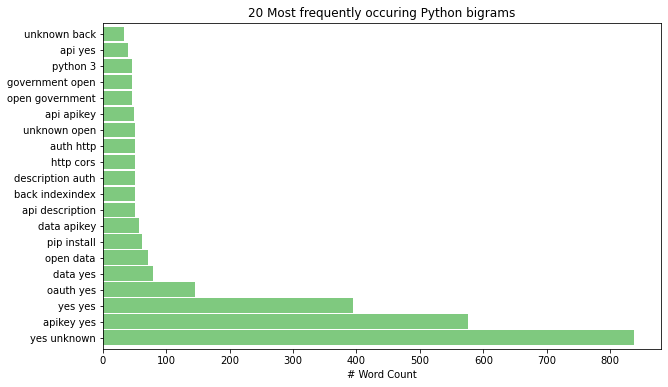

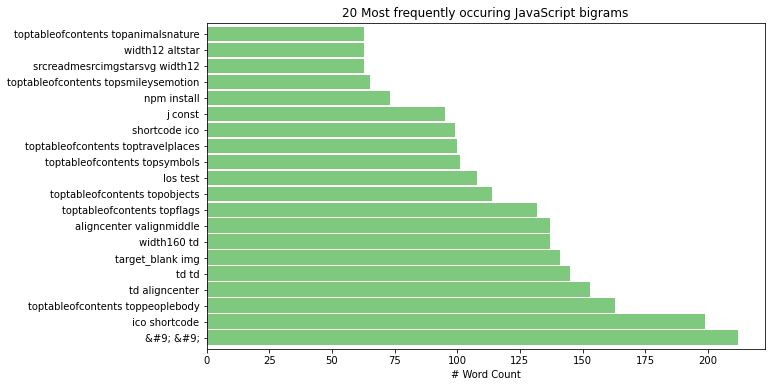

In [10]:
e.bigram_graph(python_words, javaScript_words)

In [ ]:



top_20_Python_bigrams = (pd.Series(nltk.ngrams(python_words, 2))
                      .value_counts()
                      .head(20))

top_20_Python_bigrams.head()

top_20_Python_bigrams.sort_values(ascending=False).plot.barh(colormap='Accent', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Python bigrams')
plt.ylabel('')
plt.xlabel('# Word Count')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_Python_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)
plt.show()


top_20_JavaScript_bigrams = (pd.Series(nltk.ngrams(javaScript_words, 2))
                      .value_counts()
                      .head(20))
top_20_JavaScript_bigrams.sort_values(ascending=False).plot.barh(colormap='Accent', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring JavaScript bigrams')
plt.ylabel('')
plt.xlabel('# Word Count')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_JavaScript_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)
plt.show()

In [ ]:
top_20_Java_bigrams = (pd.Series(nltk.ngrams(java_words, 2))
                      .value_counts()
                      .head(20))
top_20_Java_bigrams.sort_values(ascending=False).plot.barh(colormap='Accent', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Java bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_Python_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

# Unique words by language

In [ ]:
def get_unique_words(word_counts):
    unique_df = pd.concat([word_counts[word_counts.JavaScript == 0].sort_values(by='Python').tail(10),
           word_counts[word_counts.Python == 0].sort_values(by='JavaScript').tail(10)])
    unique_javascript_words =pd.DataFrame(unique_df.JavaScript.tail(10))
    unique_python_words =pd.DataFrame(unique_df.Python.head(10))
    display(unique_python_words)
    display(unique_javascript_words)


In [ ]:
get_unique_words(word_counts)

In [ ]:
display(unique_python_words)
display(unique_javascript_words)

In [ ]:
unique_df = pd.concat([word_counts[word_counts.JavaScript == 0].sort_values(by='Python').tail(10),
           word_counts[word_counts.Python == 0].sort_values(by='JavaScript').tail(10)])
unique_df

In [ ]:
unique_df

In [ ]:
unique_df[:10]

In [ ]:
unique_javascript_words =pd.DataFrame(unique_df.JavaScript.tail(10))

In [ ]:
unique_javascript_words

In [ ]:
unique_python_words =pd.DataFrame(unique_df.Python.head(10))
unique_python_words

# MOdeling try 2

### Create Bag of words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# create object
cv1 = CountVectorizer()
# apply to data
bag_of_words = cv1.fit_transform(train.clean_text)

In [ ]:
bag_of_words

In [ ]:
# create bow
bow = pd.DataFrame(bag_of_words.todense())
bow.columns = cv.get_feature_names()

In [ ]:
bow

### create TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
bag_of_words = tfidf.fit_transform(train.clean_text)

pd.DataFrame(bag_of_words.todense(), 
             columns=tfidf.get_feature_names())

In [ ]:
bag_of_features = pd.Series(
    dict(
        zip(
            tfidf.get_feature_names(), tfidf.idf_)))

In [ ]:
bag_of_features.sort_values(ascending=False).tail(10)

In [ ]:
bag_of_features.sort_values(ascending=False).head(10)

In [ ]:
# create bag of words with bigrams
cv2 = CountVectorizer(ngram_range=(2, 2))
bag_of_grams = cv2.fit_transform(train.clean_text)

In [ ]:
# create bow
bow2 = pd.DataFrame(bag_of_grams.todense())
bow2.columns = cv2.get_feature_names()

# Decision Tree

### prep for model seperate X-train from y-target

In [ ]:
X_train = train.clean_text
y_train = train.language

X_validate = validate.clean_text
y_validate = validate.language

X_test = test.clean_text
y_test = test.language


In [ ]:
X_train

### cv bag of words

In [ ]:
#cv = CountVectorizer() Train
X_bow = cv.fit_transform(X_train)
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X_bow, y_train)
tree.score(X_bow, y_train)

In [ ]:
#cv = CountVectorizer()
X_bow_val = cv.transform(X_validate)


tree.score(X_bow_val, y_validate)

In [ ]:
pd.Series(
    dict(
    zip(cv.get_feature_names(), 
    tree.feature_importances_))).sort_values().tail()

### cv2 bag of grams

In [ ]:
X_bow2 = cv2.fit_transform(X_train)
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X_bow2, y_train)
tree.score(X_bow2, y_train)

In [ ]:
#cv = CountVectorizer()
X_bow_val2 = cv2.transform(X_validate)


tree.score(X_bow_val2, y_validate)

In [ ]:
pd.Series(
    dict(
    zip(cv2.get_feature_names(), 
    tree.feature_importances_))).sort_values().tail()

# decision Tree

In [ ]:
def cv_countvectorizer(X_train):
    cv = CountVectorizer()

    return cv
    

In [ ]:
def get_tree(x_train, y_train, x_validate, y_validate, x_test, y_test,cv):
    '''
    Function gets Decision Tree model accuracy on train and validate data set 
    ''' 
    # create decision tree model using defaults and random state to replicate results
    tree = DecisionTreeClassifier(max_depth=3)

    # fit model on training data
    X_bow = cv.fit_transform(x_train)
    tree.fit(X_bow, y_train)
    train_score= tree.score(X_bow, y_train)
    
    # Whatever transformations we apply to X_train need to be applied to X_test
    X_bow_val = cv.transform(x_validate)
    val_score =tree.score(X_bow_val, y_validate)

    return train_score, val_score

In [ ]:
get_tree(X_train, y_train, X_validate, y_validate, X_test, y_test,cv)

In [ ]:
# Whatever transformations we apply to X_train need to be applied to X_test
cv = CountVectorizer()
X_bow = cv.fit_transform(X_train)
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X_bow, y_train)
tree.score(X_bow, y_train)

In [ ]:
# Whatever transformations we apply to X_train need to be applied to X_test
X_bow_val = cv.transform(X_validate)
tree.score(X_bow_val, y_validate)

# Forest

In [ ]:
def get_forest(x_train, y_train, x_validate, y_validate, x_test, y_test,cv):
    X_bow1 = cv1.fit_transform(X_train)
    rf = RandomForestClassifier(max_depth =6, 
                            min_samples_leaf = 2, 
                            random_state=123)
    rf.fit(X_bow1, y_train)
    train_score = rf.score(X_bow1, y_train)
    
    # Whatever transformations we apply to X_train need to be applied to X_test
    X_bow_val = cv1.transform(X_validate)
    val_score =rf.score(X_bow_val, y_validate)
    
    return train_score, val_score

In [ ]:
get_forest(X_train, y_train, X_validate, y_validate, X_test, y_test,cv)

In [ ]:
# Whatever transformations we apply to X_train need to be applied to X_test
cv1 = CountVectorizer()
X_bow1 = cv1.fit_transform(X_train)
rf = RandomForestClassifier(max_depth =6, 
                            min_samples_leaf = 2, 
                            random_state=123)
rf.fit(X_bow1, y_train)
rf.score(X_bow1, y_train)

In [ ]:
# Whatever transformations we apply to X_train need to be applied to X_test
X_bow_val = cv1.transform(X_validate)
rf.score(X_bow_val, y_validate)

# Knn

In [ ]:
def get_knn(x_train, y_train, x_validate, y_validate, x_test, y_test,cv):
    X_bow1 = cv.fit_transform(X_train)
    knn = KNeighborsClassifier(n_neighbors=6, weights='uniform')
    knn.fit(X_bow, y_train)
    train_score = knn.score(X_bow1, y_train)
    
    # Whatever transformations we apply to X_train need to be applied to X_test
    X_bow_val = cv.transform(X_validate)
    val_score =knn.score(X_bow_val, y_validate)
    
    return train_score, val_score

In [ ]:
get_knn(X_train, y_train, X_validate, y_validate, X_test, y_test,cv)

In [ ]:
cv2 = CountVectorizer()
X_bow = cv2.fit_transform(X_train)
knn = KNeighborsClassifier(n_neighbors=6, weights='uniform')
knn.fit(X_bow, y_train)
knn.score(X_bow, y_train)

In [ ]:
X_bow_val = cv2.transform(X_validate)
knn.score(X_bow_val, y_validate)

# Start Here with models...Final Run

In [ ]:
X_train,y_train,X_validate,y_validate, X_test, y_test = m.model_prep(train, validate, test)

In [ ]:
cv = m.cv_countvectorizer(X_train)

In [ ]:
DecisionTree_Train,DecisionTree_Validate=m.get_tree(X_train,y_train,X_validate,y_validate, X_test,y_test,cv)

In [ ]:
KNN_Train,KNN_Validate = m.get_knn(X_train,y_train,X_validate,y_validate, X_test,y_test,cv)

In [ ]:
RandomForest_Train,RandomForest_Validate =m.get_forest(X_train,y_train,X_validate,y_validate, X_test,y_test,cv)

In [ ]:
models = ['Baseline_Train', 'DecisionTree_Train', 'RandomForest_Train','KNN_Train','Baseline_Validate', 'DecisionTree_Validate', 'RandomForest_Validate','KNN_Validate']
def make_stats_df():
    '''
    Function creates dataframe for results of pearsonsr statistical 
    test for all features.
    '''
    evaluate_df = pd.DataFrame()
    evaluate_df['models'] = models
    return evaluate_df

def final_eval(train, validate, evaluate_df):
    base_train = 45
    DecisionTree_Train = 
    gen_train = glm_errors(train)
    base_val = baseline_mean_errors(train,validate)
    simp_val = lm_errors(validate)
    gen_val = glm_errors(validate)


    scores = [base_train, simp_train, gen_train, base_val, simp_val, gen_val]
    evaluate_df['RMSE']=scores
    
    return evaluate_df


    



In [ ]:
make_stats_df()

In [ ]:
def make_stats_df():
    '''
    Function creates dataframe for results of pearsonsr statistical 
    test for all features.
    '''
    evaluate_df = pd.DataFrame()
    evaluate_df['models'] = models
    return evaluate_df

def final_eval(train, validate, evaluate_df):
    base_train = baseline_mean_errors(train,validate)
    simp_train = lm_errors(train)
    gen_train = glm_errors(train)
    base_val = baseline_mean_errors(train,validate)
    simp_val = lm_errors(validate)
    gen_val = glm_errors(validate)


    scores = [base_train, simp_train, gen_train, base_val, simp_val, gen_val]
    evaluate_df['RMSE']=scores
    
    return evaluate_df

In [ ]:
evaluate_df = m.make_stats_df()
evaluate_df